## Trial02 : ROI
### 목표: focused image와 blurred image 사이의 수치적인 차이를 구분하기

+ 시도1) 
+ 시도2) 

In [1]:
# 필요한 라이브러리 import

import argparse
import math
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image

In [2]:
# 작업 디렉토리 위치 확인

import os 
os.getcwd()

'C:\\Users\\hannie\\Desktop\\opencv'

In [3]:
# 함수

def im2double(im):
	min_val = np.min(im.ravel())
	max_val = np.max(im.ravel())
	out = (im.astype('float') - min_val) / (max_val - min_val)
	return out


def s(x):
	temp = x>0
	return temp.astype(float)


def lbpCode(im_gray, threshold):
	width, height = im_gray.shape
	interpOff = math.sqrt(2)/2
	I = im2double(im_gray)
	pt = cv2.copyMakeBorder(I,1,1,1,1,cv2.BORDER_REPLICATE)
	right = pt[1:-1, 2:]
	left = pt[1:-1, :-2]
	above = pt[:-2, 1:-1]
	below = pt[2:, 1:-1];
	aboveRight = pt[:-2, 2:]
	aboveLeft = pt[:-2, :-2]
	belowRight = pt[2:, 2:]
	belowLeft = pt[2:, :-2]
	interp0 = right
	interp1 = (1-interpOff)*((1-interpOff) * I + interpOff * right) + interpOff *((1-interpOff) * above + interpOff * aboveRight)

	interp2 = above;
	interp3 = (1-interpOff)*((1-interpOff) * I + interpOff * left ) + interpOff *((1-interpOff) * above + interpOff * aboveLeft)

	interp4 = left;
	interp5 = (1-interpOff)*((1-interpOff) * I + interpOff * left ) + interpOff *((1-interpOff) * below + interpOff * belowLeft)

	interp6 = below;
	interp7 = (1-interpOff)*((1-interpOff) * I + interpOff * right ) + interpOff *((1-interpOff) * below + interpOff * belowRight) 

	s0 = s(interp0 - I-threshold)
	s1 = s(interp1 - I-threshold)
	s2 = s(interp2 - I-threshold)
	s3 = s(interp3 - I-threshold)
	s4 = s(interp4 - I-threshold)
	s5 = s(interp5 - I-threshold)
	s6 = s(interp6 - I-threshold)
	s7 = s(interp7 - I-threshold)
	LBP81 = s0 * 1 + s1 * 2+s2 * 4   + s3 * 8+ s4 * 16  + s5 * 32  + s6 * 64  + s7 * 128
	LBP81.astype(int)

	U = np.abs(s0 - s7) + np.abs(s1 - s0) + np.abs(s2 - s1) + np.abs(s3 - s2) + np.abs(s4 - s3) + np.abs(s5 - s4) + np.abs(s6 - s5) + np.abs(s7 - s6)
	LBP81riu2 = s0 + s1 + s2 + s3 + s4 + s5 + s6 + s7
	LBP81riu2[U > 2] = 9;

	return LBP81riu2



def lbpSharpness(im_gray, s, threshold):
	lbpmap  = lbpCode(im_gray, threshold)
	window_r = (s-1)//2;
	h, w = im_gray.shape[:2]
	map =  np.zeros((h, w), dtype=float)
	lbpmap_pad = cv2.copyMakeBorder(lbpmap, window_r, window_r, window_r, window_r, cv2.BORDER_REPLICATE)

	lbpmap_sum = (lbpmap_pad==6).astype(float) + (lbpmap_pad==7).astype(float) + (lbpmap_pad==8).astype(float) + (lbpmap_pad==9).astype(float)
	integral = cv2.integral(lbpmap_sum);
	integral = integral.astype(float)

	map = (integral[s-1:-1, s-1:-1]-integral[0:h, s-1:-1]-integral[s-1:-1, 0:w]+integral[0:h, 0:w])/math.pow(s,2);

	return map

 ## rewrite here

In [7]:
img = cv2.imread('out_of_focus0080.jpg',cv2.IMREAD_COLOR) # 사진 크기 640*512에 최적화되어있음.
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
    
# threshold가 높을수록 초점이 뚜렷한 부분이 주목됨
sharpness_map = lbpSharpness(img_gray, 21, 0.032) # s=21, threshold=0.032
sharpness_map = (sharpness_map - np.min(sharpness_map)) / (np.max(sharpness_map - np.min(sharpness_map)))
sharpness_map = (sharpness_map * 255).astype("uint8") #uint8
lbp = np.stack((sharpness_map,) , -1)

# 오츠 알고리즘으로 임계값 설정
ret, thresh_otsu = cv2.threshold(lbp, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
frame = thresh_otsu

im = Image.open('out_of_focus0080.jpg')
v,h = im.size
x=0; y=0; w=0; z=0; 


result = False;
for j in range(0,h):
    for i in range(0,v):
        if frame[j,i] == 255:
            y = j;
            result = True
            break
    if result==True:
        break
        
result = False;
for i in range(0,v):
    for j in range(0,h):
        if frame[j,i] == 255:
            x = i;
            result = True
            break
    if result==True:
        break
        
result = False;
for j in reversed(range(h)):
    for i in reversed(range(v)):
        if frame[j,i] == 255:
            z = j;
            result = True
            break
    if result==True:
        break

result = False;
for i in reversed(range(v)):
    for j in reversed(range(h)):
        if frame[j,i] == 255:
            w = i;
            result = True
            break
    if result==True:
        break
        

print(x,y)
print(w,z)

166 48
345 401


In [11]:
# 사각형 ROI 만들기

cv2.rectangle(img, (x, y), (w, z), (0, 255, 0), 2)
together = np.concatenate((img, np.stack((sharpness_map,) * 3, -1)), axis=1)
cv2.imshow('output',together)
cv2.imshow('threshold',thresh_otsu)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [70]:
# threshold를 127로 설정했을 때의 값

cv2.imshow('output',lbp)

cv2.waitKey(0)
cv2.destroyAllWindows()

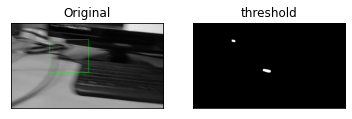

In [72]:
# plt로 간단히 확인

imgs = { 'Original': img, 'threshold' : thresh_otsu }
for i,(key, value) in enumerate(imgs.items()):
    plt.subplot(1,2,i+1)
    plt.title(key)
    plt.imshow(value, cmap = 'gray')
    plt.xticks([]); plt.yticks([])
    
plt.show()


OTSU algorithm